In [1]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM

2023-06-02 14:53:31.143612: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 14:53:31.305689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 14:53:32.560390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# loading the data
df = pd.read_csv('final_dataframe.csv')

In [3]:
print(df.shape)
df.head()

(28826, 187)


,center_0_X,center_0_Y,center_1_X,center_1_Y,obj_class,obj_X,obj_Y,obj_width,obj_height,landmark_0_0_X,...,L_Reach,L_Grasp,L_Manipulation,L_Transport,L_Place,R_Reach,R_Grasp,R_Manipulation,R_Transport,R_Place
0,195.091320,199.277472,0.000000,0.000000,4.0,0.0,0.0,1.0,1.0,203.6780,...,0,0,0,0,0,0,0,0,0,0
1,208.651174,179.422023,0.000000,0.000000,4.0,0.0,0.0,1.0,1.0,210.2895,...,0,0,0,0,0,0,0,0,0,0
2,90.084400,129.034737,0.000000,0.000000,4.0,300.0,300.0,1.0,1.0,95.7721,...,0,0,0,0,0,0,0,0,0,0
3,168.386314,161.723760,217.941821,175.335138,4.0,0.0,0.0,1.0,1.0,166.9457,...,0,0,0,0,0,0,0,0,0,0
4,242.268548,193.365412,0.000000,0.000000,4.0,0.0,0.0,1.0,1.0,236.6061,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# create a copy of the dataframe before dropping some columns
df_copy = df.copy()

# drop the object class column (it is not a pixel value and it is not needed for the model)
df_copy = df_copy.drop(['obj_class'], axis=1)

df_copy.head()

,center_0_X,center_0_Y,center_1_X,center_1_Y,obj_X,obj_Y,obj_width,obj_height,landmark_0_0_X,landmark_0_0_Y,...,L_Reach,L_Grasp,L_Manipulation,L_Transport,L_Place,R_Reach,R_Grasp,R_Manipulation,R_Transport,R_Place
0,195.091320,199.277472,0.000000,0.000000,0.0,0.0,1.0,1.0,203.6780,215.0048,...,0,0,0,0,0,0,0,0,0,0
1,208.651174,179.422023,0.000000,0.000000,0.0,0.0,1.0,1.0,210.2895,194.1755,...,0,0,0,0,0,0,0,0,0,0
2,90.084400,129.034737,0.000000,0.000000,300.0,300.0,1.0,1.0,95.7721,153.1310,...,0,0,0,0,0,0,0,0,0,0
3,168.386314,161.723760,217.941821,175.335138,0.0,0.0,1.0,1.0,166.9457,171.6965,...,0,0,0,0,0,0,0,0,0,0
4,242.268548,193.365412,0.000000,0.000000,0.0,0.0,1.0,1.0,236.6061,209.4084,...,0,0,0,0,0,0,0,0,0,0


### check the number of frame which actually have hands AND object detected

In [5]:
# get all the columns which are distance measurements
distance_columns = [col for col in df_copy.columns if 'dist' in col]
not_valid_frames = []
nb_not_valid_frames = 0

# for each row, the first distance column value should not be 0
for index, row in df_copy.iterrows():
    if row[distance_columns[0]] == 0.0:
        not_valid_frames.append(index)
        nb_not_valid_frames += 1

print("There is {} valids rows".format(df_copy.shape[0] - nb_not_valid_frames))

# drop the not valid rows (the ones with a 0.0 value for the first distance column)
df_copy = df_copy.drop(not_valid_frames, axis=0)

df_copy.shape

There is 28826 valids rows


(28826, 186)

# Splitting dataframe
In order to train our model correctly, we need to split our dataframe in 3 : training set, validation set and test set

In [6]:
# split global_set into train_set, validation_set and test_set with 70%, 15% and 15% of the data

train_set, validation_set = train_test_split(df, test_size=0.3, random_state=42)
validation_set, test_set = train_test_split(validation_set, test_size=0.5, random_state=42)

# check the shape of the train_set, validation_set and test_set
print("training set : ", train_set.shape)
print("validation set : ", validation_set.shape)
print("test set : ", test_set.shape)

training set :  (20178, 187)
validation set :  (4324, 187)
test set :  (4324, 187)


In [7]:
# count the number of frames of each class in the train_set, validation_set and test_set

# creat a list of all submovements names
submovements = ['L_Reach', 'L_Grasp', 'L_Manipulation', 'L_Transport', 'L_Place', 'R_Reach', 'R_Grasp', 'R_Manipulation', 'R_Transport', 'R_Place']

# initialize a dictionaries to store the number of frames of each class in each set
train_class_counts = {}
validation_class_counts = {}
test_class_counts = {}

# loop through all submovements and count the number of frames of each class in every set

# train_set
for submovement in submovements:
    count = train_set[submovement].value_counts().get(1, 0)
    train_class_counts[submovement] = count
print(train_class_counts)

# validation_set
for submovement in submovements:
    count = validation_set[submovement].value_counts().get(1, 0)
    validation_class_counts[submovement] = count
print(validation_class_counts)

# test_set
for submovement in submovements:
    count = test_set[submovement].value_counts().get(1, 0)
    test_class_counts[submovement] = count
print(test_class_counts)

# get the smallest number of frames of a class in the train_set, validation_set and test_set
train_min = min(train_class_counts.values())
validation_min = min(validation_class_counts.values())
test_min = min(test_class_counts.values())

print("train_min : ", train_min, "class : ", min(train_class_counts, key=train_class_counts.get))
print("validation_min : ", validation_min, "class : ", min(validation_class_counts, key=validation_class_counts.get))
print("test_min : ", test_min, "class : ", min(test_class_counts, key=test_class_counts.get))

{'L_Reach': 958, 'L_Grasp': 7557, 'L_Manipulation': 4766, 'L_Transport': 3090, 'L_Place': 924, 'R_Reach': 1294, 'R_Grasp': 3077, 'R_Manipulation': 9195, 'R_Transport': 2689, 'R_Place': 1201}
{'L_Reach': 204, 'L_Grasp': 1625, 'L_Manipulation': 1025, 'L_Transport': 684, 'L_Place': 169, 'R_Reach': 298, 'R_Grasp': 642, 'R_Manipulation': 1973, 'R_Transport': 562, 'R_Place': 253}
{'L_Reach': 203, 'L_Grasp': 1617, 'L_Manipulation': 1057, 'L_Transport': 690, 'L_Place': 161, 'R_Reach': 302, 'R_Grasp': 663, 'R_Manipulation': 2016, 'R_Transport': 568, 'R_Place': 230}
train_min :  924 class :  L_Place
validation_min :  169 class :  L_Place
test_min :  161 class :  L_Place


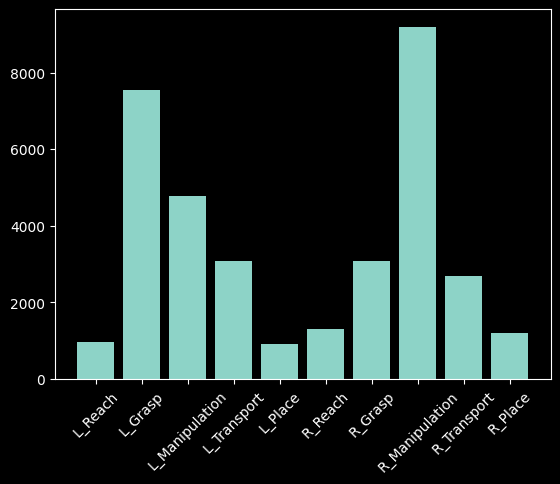

In [8]:
# plot the number of frames of each class in train_set
pl.bar(range(len(train_class_counts)), list(train_class_counts.values()), align='center')
pl.xticks(range(len(train_class_counts)), list(train_class_counts.keys()), rotation=45)
pl.show()

# Balancing dataframe
As we can see, the dataframe is not very balanced. 
L_Place is about 5 time under represented compare to R_Manipulation.

In [9]:
# balance trainings set, validation set and test set by selecting the same number of frames for each class in each set

# initialize new dataframes to store the balanced sets
balanced_train_set = pd.DataFrame()
balanced_validation_set = pd.DataFrame()
balanced_test_set = pd.DataFrame()

# loop through all submovements
for submovement in submovements:
    # get a random sample of frames from each submovement of the size of the smallest class
    balanced_train_set = pd.concat([balanced_train_set, train_set[train_set[submovement] == 1].sample(train_min, random_state=42)])
    balanced_validation_set = pd.concat([balanced_validation_set, validation_set[validation_set[submovement] == 1].sample(validation_min, random_state=42)])
    balanced_test_set = pd.concat([balanced_test_set, test_set[test_set[submovement] == 1].sample(test_min, random_state=42)])
    
print("balanced training set : ", balanced_train_set.shape)
print("balanced validation set : ", balanced_validation_set.shape)
print("balanced test set : ", balanced_test_set.shape)

balanced training set :  (9240, 187)
balanced validation set :  (1690, 187)
balanced test set :  (1610, 187)


/tmp/ipykernel_3851208/2591671160.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(train_class_counts.keys(), rotation=45)
/tmp/ipykernel_3851208/2591671160.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(train_class_counts.keys(), rotation=45)


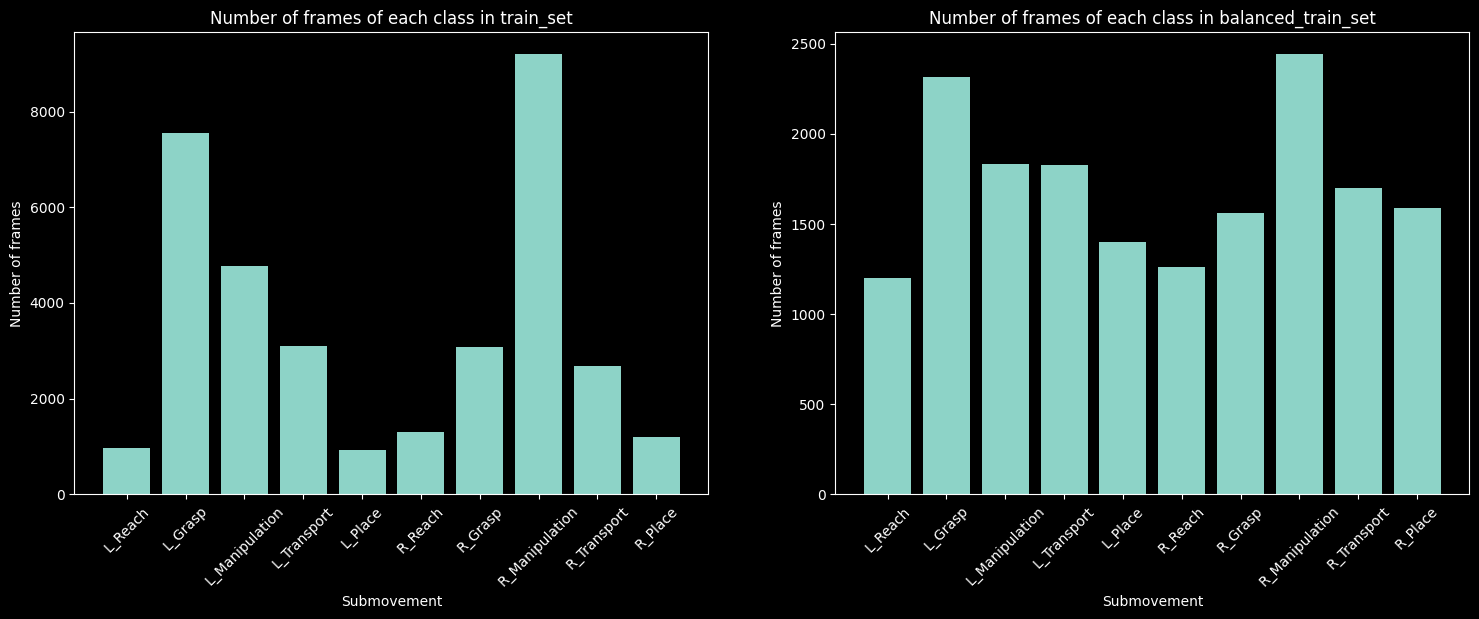

In [10]:

# train_set and balanced_train_set comparison
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(18, 6))
ax1.bar(train_class_counts.keys(), train_class_counts.values())
ax1.set_title("Number of frames of each class in train_set")
ax1.set_xlabel("Submovement")
ax1.set_ylabel("Number of frames")
ax1.set_xticklabels(train_class_counts.keys(), rotation=45)
ax2.bar(train_class_counts.keys(), balanced_train_set[submovements].sum())
ax2.set_title("Number of frames of each class in balanced_train_set")
ax2.set_xlabel("Submovement")
ax2.set_ylabel("Number of frames")
ax2.set_xticklabels(train_class_counts.keys(), rotation=45)
pl.show()

The sets are now balanced. They are not perfectly balanced :  as we can see we still have quite a big disparity between L_Place and R_Manipulation but it is way better than before.

Before => 1:10

Now => 1:2

# Model creation

### Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

X_train = balanced_train_set.iloc[:, :-10].values
y_train = balanced_train_set.iloc[:, -10:].values

X_val = balanced_validation_set.iloc[:, :-10].values
y_val = balanced_validation_set.iloc[:, -10:].values

X_test = balanced_test_set.iloc[:, :-10].values
y_test = balanced_test_set.iloc[:, -10:].values

# Scaling features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Function to create the CNN model
def create_model():
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1:])))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the KerasClassifier model
keras_model = KerasClassifier(build_fn=create_model)

# Define the grid of hyperparameters to test
param_grid = {
    'epochs': [100, 200],
    'batch_size': [16, 32]
}

# Perform grid search for hyperparameters using cross-validation
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and corresponding performance
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)


Epoch 1/100


/tmp/ipykernel_3856783/767361476.py:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=create_model)


385/385 [==============================] - 1s 2ms/step - loss: 14.1358 - accuracy: 0.1166
Epoch 2/100
385/385 [==============================] - 1s 2ms/step - loss: 25.0528 - accuracy: 0.1219
Epoch 3/100
385/385 [==============================] - 1s 2ms/step - loss: 13.5725 - accuracy: 0.1119
Epoch 4/100
385/385 [==============================] - 1s 2ms/step - loss: 16.2630 - accuracy: 0.1195
Epoch 5/100
385/385 [==============================] - 1s 2ms/step - loss: 16.9292 - accuracy: 0.1209
Epoch 6/100
385/385 [==============================] - 1s 2ms/step - loss: 16.6304 - accuracy: 0.1188
Epoch 7/100
385/385 [==============================] - 1s 2ms/step - loss: 17.0892 - accuracy: 0.1119
Epoch 8/100
385/385 [==============================] - 1s 2ms/step - loss: 14.9859 - accuracy: 0.1106
Epoch 9/100
385/385 [==============================] - 1s 2ms/step - loss: 14.6660 - accuracy: 0.1185
Epoch 10/100
385/385 [==============================] - 1s 2ms/step - loss: 14.7406 - accuracy

### CNN model

In [18]:
# Separating features (detection parameters) and labels (submovement classes)
from sklearn.preprocessing import MinMaxScaler

X_train = balanced_train_set.iloc[:, :-10].values
y_train = balanced_train_set.iloc[:, -10:].values

X_val = balanced_validation_set.iloc[:, :-10].values
y_val = balanced_validation_set.iloc[:, -10:].values

X_test = balanced_test_set.iloc[:, :-10].values
y_test = balanced_test_set.iloc[:, -10:].values

print("X_train : ", X_train.shape)
print("X_train : ", type(X_train))
print("y_train : ", y_train.shape)
print("y_train : ", type(y_train))

# Scaling features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# CNN construction
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1:])))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Model compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model training
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

# validation set prediction
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# calculate accuracy and F1-score on validation set
val_accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
val_F1 = f1_score(np.argmax(y_val, axis=1), y_val_pred, average='weighted')
print("Accuracy du modèle CNN sur le jeu de validation : ", val_accuracy)
print("F1-score du modèle CNN sur le jeu de validation : ", val_F1)

# test set prediction
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# calculate accuracy and F1-score on test set
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
test_F1 = f1_score(np.argmax(y_test, axis=1), y_test_pred, average='weighted')
print("Accuracy du modèle CNN sur le jeu de test : ", test_accuracy)
print("F1-score du modèle CNN sur le jeu de test : ", test_F1)

X_train :  (9240, 177)
X_train :  <class 'numpy.ndarray'>
y_train :  (9240, 10)
y_train :  <class 'numpy.ndarray'>
Epoch 1/100
578/578 [==============================] - 4s 4ms/step - loss: 39637.2383 - accuracy: 0.1062 - val_loss: 179804.9688 - val_accuracy: 0.2550
Epoch 2/100
578/578 [==============================] - 2s 4ms/step - loss: 1740586.1250 - accuracy: 0.1143 - val_loss: 4585453.0000 - val_accuracy: 0.1450
Epoch 3/100
578/578 [==============================] - 3s 4ms/step - loss: 15012946.0000 - accuracy: 0.1068 - val_loss: 21068482.0000 - val_accuracy: 0.2550
Epoch 4/100
578/578 [==============================] - 2s 3ms/step - loss: 52964168.0000 - accuracy: 0.1053 - val_loss: 54068752.0000 - val_accuracy: 0.0237
Epoch 5/100
578/578 [==============================] - 2s 4ms/step - loss: 130379816.0000 - accuracy: 0.1094 - val_loss: 157030832.0000 - val_accuracy: 0.0012
Epoch 6/100
578/578 [==============================] - 2s 4ms/step - loss: 248159040.0000 - accuracy: 0.1

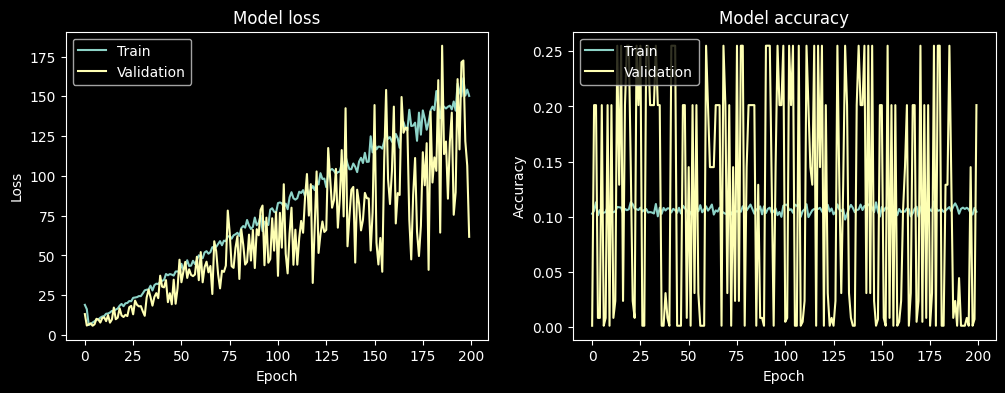

In [17]:
# plot accuray and loss curves for validation and test sets
pl.figure(figsize=(12, 4))
pl.subplot(1, 2, 1)
pl.plot(history.history['loss'])
pl.plot(history.history['val_loss'])
pl.title('Model loss')
pl.ylabel('Loss')
pl.xlabel('Epoch')
pl.legend(['Train', 'Validation'], loc='upper left')
pl.subplot(1, 2, 2)
pl.plot(history.history['accuracy'])
pl.plot(history.history['val_accuracy'])
pl.title('Model accuracy')
pl.ylabel('Accuracy')
pl.xlabel('Epoch')
pl.legend(['Train', 'Validation'], loc='upper left')
pl.show()


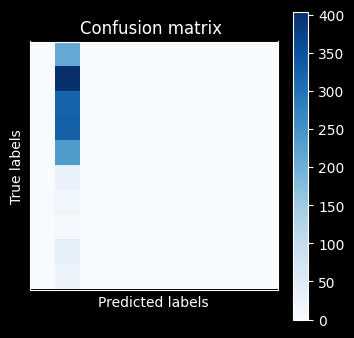

In [13]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)
pl.figure(figsize=(4, 4))
pl.imshow(cm, cmap=pl.cm.Blues)
pl.xlabel("Predicted labels")
pl.ylabel("True labels")
pl.xticks([], [])
pl.yticks([], [])
pl.title('Confusion matrix ')
pl.colorbar()
pl.show()

### SVM : One vs Rest model

In [14]:
# Separating features (detection parameters) and labels (submovement classes)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

X_train = balanced_train_set.iloc[:, :-10].values
y_train = balanced_train_set.iloc[:, -10:].values

X_val = balanced_validation_set.iloc[:, :-10].values
y_val = balanced_validation_set.iloc[:, -10:].values

X_test = balanced_test_set.iloc[:, :-10].values
y_test = balanced_test_set.iloc[:, -10:].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# SVM One-vs-Rest classifier construction
svm_classifier = OneVsRestClassifier(SVC(kernel='rbf', C=1.0))

# model training
svm_classifier.fit(X_train, y_train)

# validation set prediction
y_val_pred = svm_classifier.predict(X_val)

# calculate accuracy and F1-score on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_F1 = f1_score(y_val, y_val_pred, average='weighted')
print("Exactitude du modèle SVM sur le jeu de validation : ", val_accuracy)
print("Score F1 du modèle SVM sur le jeu de validation : ", val_F1)

# test set prediction
y_test_pred = svm_classifier.predict(X_test)

# calculate accuracy and F1-score on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_F1 = f1_score(y_test, y_test_pred, average='weighted')
print("Exactitude du modèle SVM sur le jeu de test : ", test_accuracy)
print("Score F1 du modèle SVM sur le jeu de test : ", test_F1)

Exactitude du modèle SVM sur le jeu de validation :  0.0
Score F1 du modèle SVM sur le jeu de validation :  0.0
Exactitude du modèle SVM sur le jeu de test :  0.0
Score F1 du modèle SVM sur le jeu de test :  0.0


53/53 [==============================] - 0s 2ms/step


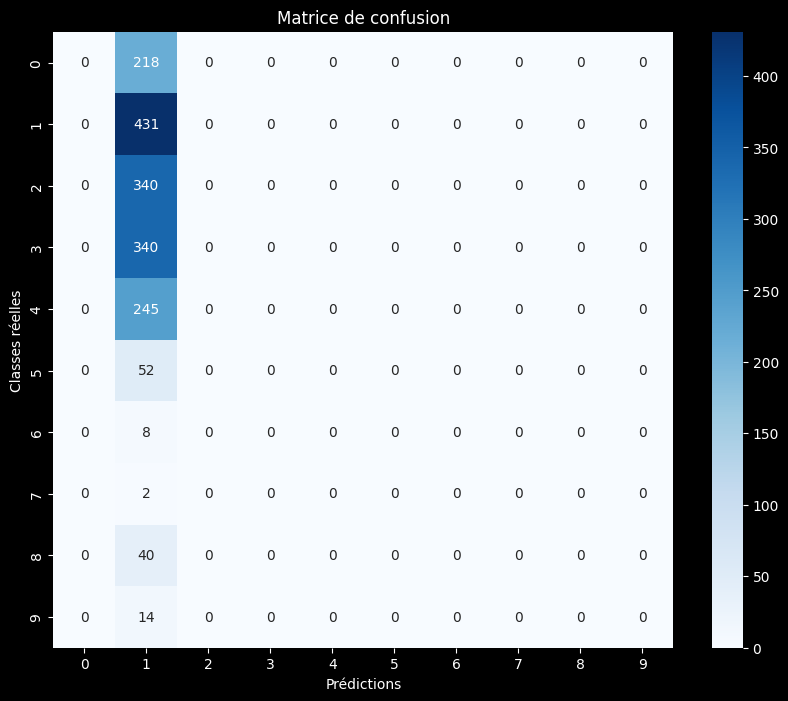

Model accuracy :  0.25502958579881657


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# validation set prediction
y_val_pred = model.predict(X_val)

# conversion of predictions to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# calculate confusion matrix
confusion_mat = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Classes réelles')
plt.title('Matrice de confusion')
plt.show()

# calculate accuracy on validation set
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
print("Model accuracy : ", accuracy)